<a href="https://colab.research.google.com/github/antonFJohansson/FFA_wasp/blob/master/Langevin_Code_new_new_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

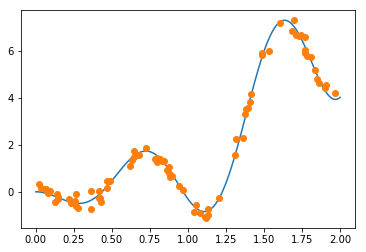

In [28]:
### For Neural network here

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data


## Generate the data
x = np.arange(0,2,0.001)
y = x**3 - x*2*np.sin(7*x) 
plt.plot(x,y)
np.random.seed(1000)

noise_std = 0.2
N = 80 ## Had 60
x_data = np.random.uniform(0,2,N)
y_data = x_data**3 - x_data*2*np.sin(7*x_data) + np.random.normal(0, noise_std, N)
plt.plot(x_data,y_data, linewidth = 0, marker = 'o')

x_t = torch.from_numpy(x_data).view(N,1).float()
y_t = torch.from_numpy(y_data).view(N,1).float()

data_vec = torch.cat((x_t,y_t), 1)
mini_batch_size = 40


gen_plot_x = np.arange(-2,4,0.001)
gen_plot_y = gen_plot_x**3 - gen_plot_x*2*np.sin(7*gen_plot_x) 


train_loader = torch.utils.data.DataLoader(data_vec, batch_size = mini_batch_size, shuffle = True)

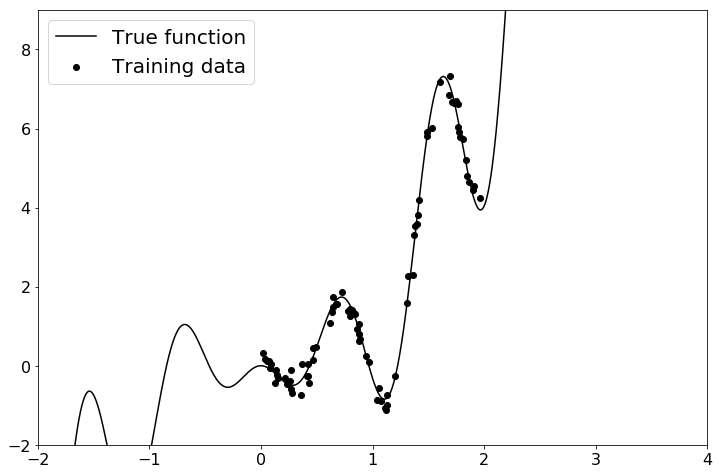

In [38]:
plt.figure(figsize=(12,8))
plt.plot(gen_plot_x, gen_plot_y, 'k-', label='True function');
plt.scatter(x_data, y_data, marker='o', color='black', label='Training data')
plt.legend(prop={'size': 20});
plt.ylim((-2,9)); plt.yticks(fontsize=16)
plt.xlim((-2,4)); plt.xticks(fontsize=16)

plt.savefig("gen.pdf", bbox_inches='tight')
files.download("gen.pdf") 
plt.show()

In [35]:
import torch.nn.functional as F

class Network(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(1,50)
    self.fc2 = nn.Linear(50,50)
    self.fc3 = nn.Linear(50,50)
    self.fc4 = nn.Linear(50, 1)
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

max_epoch = 80000 #80000 worked well

def lr_sched(t, max_epoch = max_epoch):
  
  k = (0.0000001-0.00005) / (max_epoch - 1)
  m = 0.00005-k*1
  step=k*t+m
  
  return step

def lr_sched(t):
  
  b=100
  a=0.002
  g=0.55
  step=a*np.power((b+t),-g)
  
  return step

  
torch.manual_seed(0)
np.random.seed(2)
  
my_net = Network()
loss_fn = nn.MSELoss()



def l2_loss(network):
  
  tot_loss = 0
  
  for param in network.parameters():
    tot_loss = tot_loss + (param**2).sum()
  return tot_loss


x_plot = np.arange(-2,4,0.01)
x_plot_t = torch.from_numpy(x_plot).view(x_plot.shape[0],1).float()
store_results = torch.zeros(max_epoch - int(0.9*max_epoch), x_plot.shape[0])
indk = 0

for epoch in range(max_epoch):
  
  for data in train_loader:
    
    my_net.zero_grad()
    x_val = data[:,0].view(mini_batch_size, 1)
    y_val = data[:,1].view(mini_batch_size, 1)
    
    
    out = my_net(x_val)
    loss = N*loss_fn(out, y_val) + 5e-5*l2_loss(my_net)#N*loss_fn(out, y_val) + 5e-4*l2_loss(my_net)
    loss.backward()
    
    lr = lr_sched(epoch) ## Might change later to each iteration
    for param in my_net.parameters():
      param.data = param.data - lr/2 * param.grad.data - torch.Tensor(param.data.shape).normal_(0,np.sqrt(lr))
      
  ## Save last 10% of samples as posterior samples
  if epoch > int(0.9*max_epoch):
      with torch.no_grad():
        
        out_plot = my_net(x_plot_t).detach()
        store_results[indk,:] = out_plot[:,0]
        indk +=1
      
  
  if epoch % (max_epoch / 10) == 0 or epoch == max_epoch -1:
    print('Epoch {} Train Loss {:.2f} lr {:.7f}'.format(epoch, loss.item(), lr))



Epoch 0 Train Loss 658.89 lr 0.0001589
Epoch 8000 Train Loss 27.36 lr 0.0000142
Epoch 16000 Train Loss 26.45 lr 0.0000097
Epoch 24000 Train Loss 20.01 lr 0.0000078
Epoch 32000 Train Loss 13.69 lr 0.0000066
Epoch 40000 Train Loss 17.53 lr 0.0000059
Epoch 48000 Train Loss 9.88 lr 0.0000053
Epoch 56000 Train Loss 17.69 lr 0.0000049
Epoch 64000 Train Loss 16.49 lr 0.0000045
Epoch 72000 Train Loss 10.79 lr 0.0000043
Epoch 79999 Train Loss 12.76 lr 0.0000040


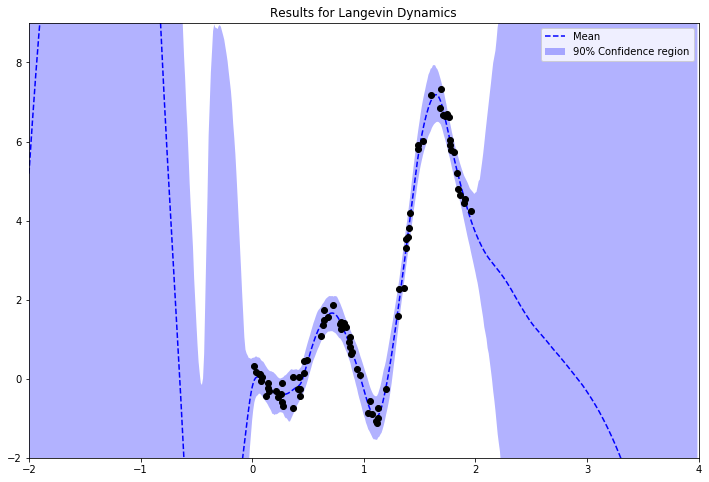

In [22]:
## Take out a subsample of the last 10% of samples to avoid correlation
row_ind = [k for k in range(max_epoch - int(0.9*max_epoch)) if k % 10 == 0]
store_resultss = store_results[row_ind,:]
out_numpy = store_resultss.numpy()

## mean, upper boundary, lower boundary
out_mean = np.mean(out_numpy, 0)
out_uq = np.quantile(out_numpy, 0.95, 0)
out_lq = np.quantile(out_numpy, 0.05, 0)


fig, ax = plt.subplots()
ax.plot(x_plot,out_mean, 'b--', label = 'Mean')
ax.fill_between(x_plot, out_lq, out_uq, facecolor='b', alpha=0.3, label = '90% Confidence region')
#ax.plot(x_plot,out_uq)
#ax.plot(x_plot,out_lq)

ax.plot(x_data,y_data,'k', linewidth = 0, marker = 'o',)
ax.set_xlim(-2, 4)
ax.set_ylim(-2, 9)
ax.set_title('Results for Langevin Dynamics')
fig.set_size_inches(12, 8, forward=True)
ax.legend()

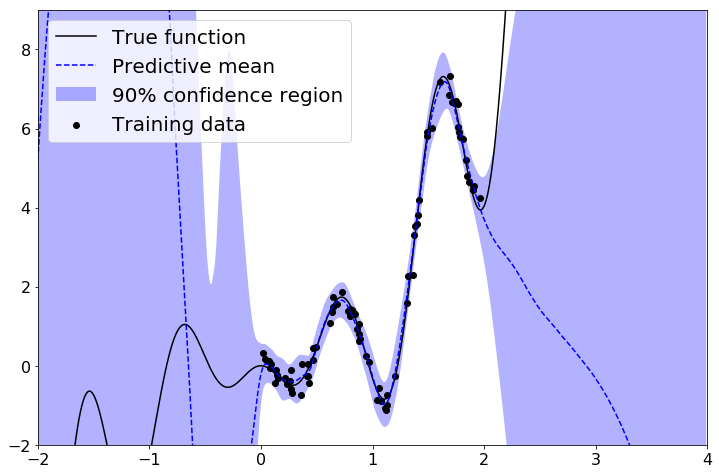

In [36]:
from google.colab import files
## Take out a subsample of the last 10% of samples to avoid correlation
row_ind = [k for k in range(max_epoch - int(0.9*max_epoch)) if k % 10 == 0]
store_resultss = store_results[row_ind,:]
out_numpy = store_resultss.numpy()

## mean, upper boundary, lower boundary
out_mean = np.mean(out_numpy, 0)
#out_uq = np.quantile(out_numpy, 0.95, 0)
#out_lq = np.quantile(out_numpy, 0.05, 0)

out_std = np.std(out_numpy, 0)


plt.figure(figsize=(12,8))
plt.plot(gen_plot_x, gen_plot_y, 'k-', label='True function');
plt.fill_between(x_plot, 
                 out_mean + 1.645 * out_std, 
                 out_mean - 1.645 * out_std, 
                 alpha=0.3, facecolor='blue', label='90% confidence region')
plt.plot(x_plot, out_mean, 'b--', label='Predictive mean');
plt.scatter(x_data, y_data, marker='o', color='black', label='Training data')
plt.legend(prop={'size': 20});
plt.ylim((-2,9)); plt.yticks(fontsize=16)
plt.xlim((-2,4)); plt.xticks(fontsize=16)

plt.savefig("Langevin.pdf", bbox_inches='tight')
files.download("Langevin.pdf") 
plt.show()

In [31]:
## Ensemble of networks here then


max_epoch = 20000

def lr_sched(t, max_epoch = max_epoch):
  
  k = (0.0001-0.001) / (max_epoch - 1)
  m = 0.001-k*1
  step=k*t+m
  
  return step

def l2_loss(network):
  
  tot_loss = 0
  
  for param in network.parameters():
    tot_loss = tot_loss + (param**2).sum()
  return tot_loss

num_loops = 20
torch.manual_seed(0)
np.random.seed(2)
loss_fn = nn.MSELoss()
x_plot = np.arange(-2,4,0.01)
x_plot_t = torch.from_numpy(x_plot).view(x_plot.shape[0],1).float()
store_results = torch.zeros(num_loops, x_plot.shape[0])

for jjj in range(num_loops):

  new_net = Network()




  for epoch in range(max_epoch):

    for data in train_loader:

      new_net.zero_grad()
      x_val = data[:,0].view(mini_batch_size, 1)
      y_val = data[:,1].view(mini_batch_size, 1)


      out = new_net(x_val)
      loss = loss_fn(out, y_val) + 5e-3*l2_loss(new_net)#N*loss_fn(out, y_val) + 5e-4*l2_loss(my_net)
      loss.backward()
      lr = lr_sched(epoch) ## Might change later to each iteration
      for param in new_net.parameters():
        param.data = param.data - lr * param.grad.data

    if epoch % (max_epoch / 10) == 0 or epoch == max_epoch -1:
      print('Epoch {} Train Loss {:.2f} lr {:.7f}'.format(epoch, loss.item(), lr))



  out = new_net(x_plot_t)
  store_results[jjj,:] = out[:,0]

Epoch 0 Train Loss 8.94 lr 0.0010000
Epoch 2000 Train Loss 1.61 lr 0.0009100
Epoch 4000 Train Loss 1.44 lr 0.0008200
Epoch 6000 Train Loss 1.27 lr 0.0007300
Epoch 8000 Train Loss 1.00 lr 0.0006400
Epoch 10000 Train Loss 0.80 lr 0.0005500
Epoch 12000 Train Loss 0.67 lr 0.0004600
Epoch 14000 Train Loss 0.56 lr 0.0003700
Epoch 16000 Train Loss 0.49 lr 0.0002800
Epoch 18000 Train Loss 0.53 lr 0.0001900
Epoch 19999 Train Loss 0.51 lr 0.0001000
Epoch 0 Train Loss 14.19 lr 0.0010000
Epoch 2000 Train Loss 1.36 lr 0.0009100
Epoch 4000 Train Loss 1.26 lr 0.0008200
Epoch 6000 Train Loss 1.13 lr 0.0007300
Epoch 8000 Train Loss 1.06 lr 0.0006400
Epoch 10000 Train Loss 0.97 lr 0.0005500
Epoch 12000 Train Loss 0.72 lr 0.0004600
Epoch 14000 Train Loss 0.58 lr 0.0003700
Epoch 16000 Train Loss 0.56 lr 0.0002800
Epoch 18000 Train Loss 0.52 lr 0.0001900
Epoch 19999 Train Loss 0.51 lr 0.0001000
Epoch 0 Train Loss 11.32 lr 0.0010000
Epoch 2000 Train Loss 1.46 lr 0.0009100
Epoch 4000 Train Loss 1.64 lr 0.000

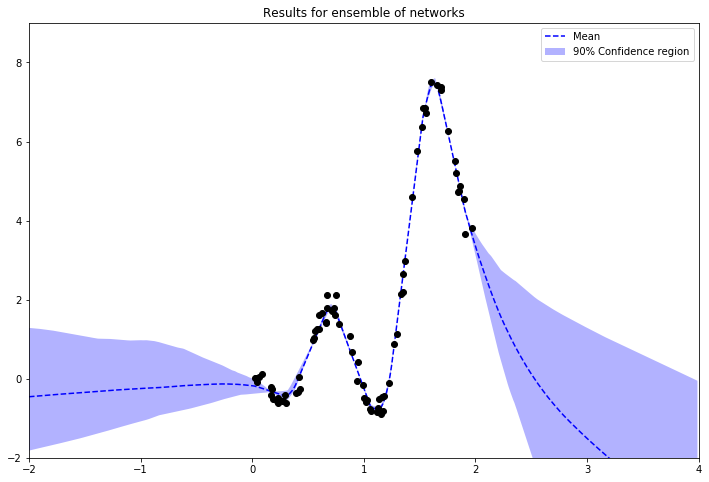

In [0]:
## Take out a subsample of the last 10% of samples to avoid correlation
store_resultss = store_results.detach()
out_numpy = store_resultss.numpy()

## mean, upper boundary, lower boundary
out_mean = np.mean(out_numpy, 0)
out_uq = np.quantile(out_numpy, 0.95, 0)
out_lq = np.quantile(out_numpy, 0.05, 0)


fig, ax = plt.subplots()
ax.plot(x_plot,out_mean, 'b--', label = 'Mean')
ax.fill_between(x_plot, out_lq, out_uq, facecolor='b', alpha=0.3, label = '90% Confidence region')
#ax.plot(x_plot,out_uq)
#ax.plot(x_plot,out_lq)

ax.plot(x_data,y_data,'k', linewidth = 0, marker = 'o',)
ax.set_xlim(-2, 4)
ax.set_ylim(-2, 9)
ax.set_title('Results for ensemble of networks')
fig.set_size_inches(12, 8, forward=True)
ax.legend()

In [0]:
store_results

tensor([[-4.0979e-01, -4.0894e-01, -4.0809e-01,  ...,  1.6981e+01,
          1.7031e+01,  1.7081e+01],
        [ 1.4593e-02,  1.1890e-02,  9.1870e-03,  ...,  1.6990e+01,
          1.7043e+01,  1.7096e+01],
        [ 3.8910e-02,  3.6110e-02,  3.3310e-02,  ...,  1.8211e+01,
          1.8269e+01,  1.8326e+01],
        ...,
        [-2.3750e-03, -4.3124e-03, -6.2498e-03,  ...,  1.5688e+01,
          1.5736e+01,  1.5783e+01],
        [-2.2282e-01, -2.2288e-01, -2.2293e-01,  ...,  1.7465e+01,
          1.7519e+01,  1.7574e+01],
        [-3.8092e-01, -3.8032e-01, -3.7973e-01,  ...,  1.7119e+01,
          1.7171e+01,  1.7224e+01]], grad_fn=<CopySlices>)